In [1]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [462]:
import os
import re

from scipy import misc

from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional
from unpack_mnist import get_labeled_data,  view_image
from sklearn.metrics import accuracy_score

# Загрузка данных mnist

In [468]:
X_mnist_train, y_mnist_train = get_labeled_data('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000
i: 10000
i: 11000
i: 12000
i: 13000
i: 14000
i: 15000
i: 16000
i: 17000
i: 18000
i: 19000
i: 20000
i: 21000
i: 22000
i: 23000
i: 24000
i: 25000
i: 26000
i: 27000
i: 28000
i: 29000
i: 30000
i: 31000
i: 32000
i: 33000
i: 34000
i: 35000
i: 36000
i: 37000
i: 38000
i: 39000
i: 40000
i: 41000
i: 42000
i: 43000
i: 44000
i: 45000
i: 46000
i: 47000
i: 48000
i: 49000
i: 50000
i: 51000
i: 52000
i: 53000
i: 54000
i: 55000
i: 56000
i: 57000
i: 58000
i: 59000


In [275]:
X_mnist_test, y_mnist_test = get_labeled_data('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000


# Загрузка данных bigalphabet

In [494]:
def get_ba_data():
    files_list = os.listdir('BigAlphabet_29x29_16pt_Arial_Reg')
    data = []
    labels = []
    for filename in files_list:
        try:
            letter = re.findall(r'\d+', filename)[0]
        except:
            continue
        labels.append(letter)
        image = misc.imread(os.path.join('BigAlphabet_29x29_16pt_Arial_Reg',filename), flatten=1)
        data.append(image)
    
    return 255 - array(data), array(labels).reshape((-1, 1))

X_ba, y_ba = get_ba_data()

In [573]:
X_ba_train, X_ba_test, y_ba_train, y_ba_test = train_test_split(X_ba, y_ba.astype('uint8'), test_size=0.2, random_state=42)

# Реализация ограниченной машины Больцмана

In [517]:
class RBM:
    
    def __init__(self, X, y=None, hidden_number=500, learning_rate=0.01):
        """X - входные данных [n_samples, n_features]
        w – матрица весов [n_features+1, hidden_number+1]"""
        self.X = X
        self.y = y
        self.visible_number = X.shape[1]
        self.hidden_number = hidden_number
        self.learning_rate = learning_rate
        self.w = rand(self.visible_number + 1, hidden_number + 1) - .5
        
        self.v_0_extended_placeholder = ones(self.visible_number + 1)
        self.v_k_extended_placeholder = ones(self.visible_number + 1)
        self.h_0_extended_placeholder = ones(self.hidden_number + 1)
        self.h_k_extended_placeholder = ones(self.hidden_number + 1)
    
    def _sigmoid(self, x):
        return 1 / (1 + exp(-x))
    
    def _sampling(self, p):
        return (p - rand(*p.shape) >= 0).astype(float)
        #return (p - 0.5 >= 0).astype(float)
        #return p
    
    def v_from_h(self, h, activation_func=None):
        if activation_func is None:
            activation_func = self._sigmoid
        h_extended = ones(self.hidden_number + 1)
        h_extended[:-1] = h
        p_v = activation_func(matmul(self.w, h_extended.reshape((-1, 1))))[:-1].reshape(-1)   # todo проверить шейп
        return self._sampling(p_v)
    
    def h_from_v(self, v, activation_func=None):
        if activation_func is None:
            activation_func = self._sigmoid
        v_extended = ones(self.visible_number + 1)
        v_extended[:-1] = v
        p_h = activation_func(matmul(self.w.T, v_extended.reshape((-1, 1))))[:-1].reshape(-1)
        return self._sampling(p_h)
    
    def _cd_pass(self, v, k=2):
        # приведение v к двоичному виду
        # v_0 = (v - 30 >= 0).astype(float)    
        v_0 = self._sampling(v)
        h_0 = self.h_from_v(v)
        
        v_k = copy(v_0)
        h_k = copy(h_0)
        for i in range(k):
            v_k = self.v_from_h(h_k)
            h_k = self.h_from_v(v_k)
        
        self.v_0_extended_placeholder[:-1] = v_0
        self.v_k_extended_placeholder[:-1] = v_k
        self.h_0_extended_placeholder[:-1] = h_0
        self.h_k_extended_placeholder[:-1] = h_k
        self.w += self.learning_rate * (matmul(self.v_0_extended_placeholder.reshape((-1, 1)), self.h_0_extended_placeholder.reshape((-1, 1)).T) - matmul(self.v_k_extended_placeholder.reshape((-1, 1)), self.h_k_extended_placeholder.reshape((-1, 1)).T))
    
    def train(self, one_pass=True, epochs=15):
        # todo перейти на минибатчи и несколько эпох
        # todo определить learning_rate
        if one_pass:
            for i in range(self.X.shape[0]):
                if i % 5000 == 0:
                    print(f'i: {i}')
                self._cd_pass(self.X[i])
        else:
            for epoch in range(epochs):
                print(f'Эпоха {epoch}')
                for i in range(self.X.shape[0]):
                    self._cd_pass(self.X[i])
    
    def predict(self, v):
        h = self.h_from_v(v)
        return self.v_from_h(h)

# Обучение RBM на данных mnist

In [522]:
rbm_mnist = RBM(X_mnist_train.reshape((-1, 784)), y_mnist_train.reshape(-1), hidden_number=100)

In [523]:
rbm_mnist.train()

i: 0


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


i: 5000
i: 10000
i: 15000
i: 20000
i: 25000
i: 30000
i: 35000
i: 40000
i: 45000
i: 50000
i: 55000


# Обучение RBM на данных big alphabet

In [518]:
rbm_ba = RBM(X_ba_train.reshape((-1, 841)), y_ba_train.reshape(-1), hidden_number=100)

In [519]:
rbm_ba.train(one_pass=False)

Эпоха 0


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Эпоха 1
Эпоха 2
Эпоха 3
Эпоха 4
Эпоха 5
Эпоха 6
Эпоха 7
Эпоха 8
Эпоха 9
Эпоха 10
Эпоха 11
Эпоха 12
Эпоха 13
Эпоха 14


# Визуализация построенных сетью изображений

In [482]:
def compare_reconstructed(img, rbm, size):
    pred = rbm.predict(img.reshape((-1, size * size))).reshape((size, size))
    figsize(10, 5)
    fig, (axes1, axes2) = subplots(nrows=1, ncols=2)
    axes1.imshow(img, cmap=cm.gray)
    axes2.imshow(pred, cmap=cm.gray)

## mnist

/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


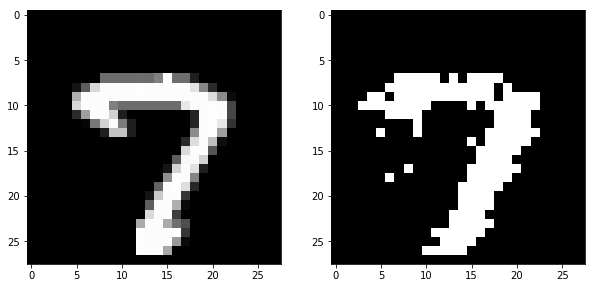

In [533]:
compare_reconstructed(X_mnist_train[52], rbm_mnist, 28)

## big alphabet

/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


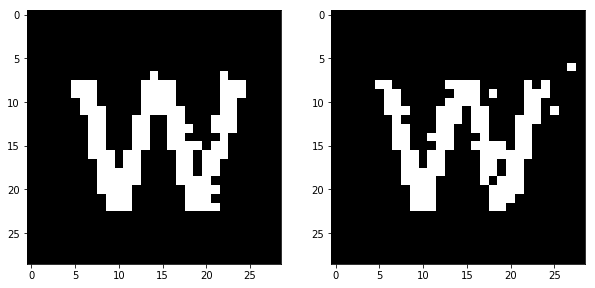

In [521]:
compare_reconstructed(X_ba_train[52], rbm_ba, 29)

# Визуализация матриц весов rbm

In [535]:
def show_weights(w, size=28):
    print('Максимум: {}, минимум: {}'.format(w.max(), w.min()))

    figsize(10, 10)
    fig, axes = subplots(nrows=10, ncols=10)
    i = 0
    for row in axes:
        for axis in row:
            axis.set_xticks([])
            axis.set_yticks([])
            axis.imshow(w[:, i].reshape((size, size)), cmap=cm.gray)
            i += 1

## mnist

Максимум: 4.221983651596699, минимум: -3.17428838142705


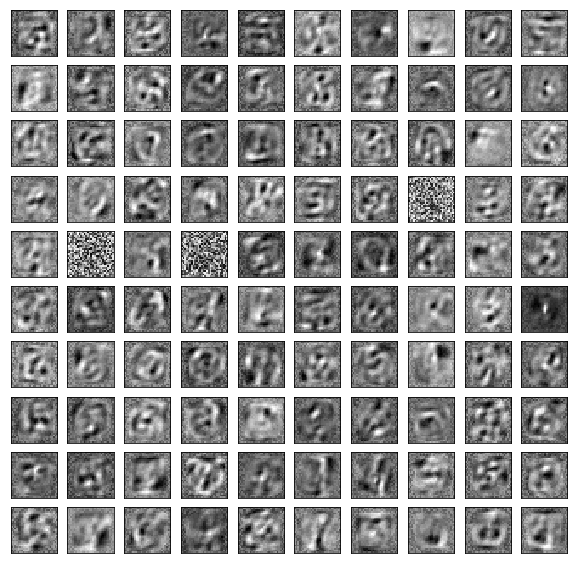

In [536]:
show_weights(rbm_mnist.w[:-1, :-1], size=28)

## big alphabet

Максимум: 1.573149179366429, минимум: -1.5235656944319922


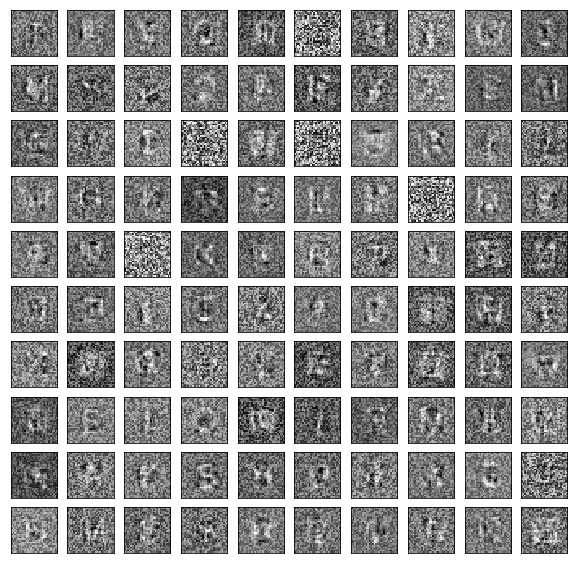

In [537]:
show_weights(rbm_ba.w[:-1, :-1], size=29)

# Однослойная сеть для классификации

In [544]:
loss_fn = torch.nn.NLLLoss()
batch_size = 10
H = 100
learning_rate = 1e-4

In [585]:
def train_nn(model, optimizer, X_train_var_batches, y_train_var_batches, X_test_var, y_test, epochs=15):
    for epoch in range(epochs):
        print(f'Эпоха {epoch}')

        for t in range(X_train_var_batches.shape[0]):
            x = X_train_var_batches[t, :, :]

            y_pred = model(x)

            loss = loss_fn(y_pred, y_train_var_batches[t, :])

            model.zero_grad()
            loss.backward()

            optimizer.step()

        print('Точность на тестовой выборке {:.2%}\n'.format(accuracy_score(y_test.reshape(-1), model(X_test_var).max(1)[1].data.numpy())))

## mnist

In [556]:
D_in_mnist, D_out_mnist = 784, 10

In [557]:
X_mnist_train_var = torch.autograd.Variable(torch.from_numpy(X_mnist_train.reshape((-1, 784))))
y_mnist_train_var = torch.autograd.Variable(torch.from_numpy(y_mnist_train).type(torch.LongTensor), requires_grad=False)

X_mnist_train_var_batches = torch.autograd.Variable(torch.from_numpy(X_mnist_train.reshape((6000, 10, 784))))
y_mnist_train_var_batches = torch.autograd.Variable(torch.from_numpy(y_mnist_train.reshape((6000, 10))).type(torch.LongTensor), requires_grad=False)

X_mnist_test_var = torch.autograd.Variable(torch.from_numpy(X_mnist_test.reshape((-1, 784))), requires_grad=False)

In [558]:
model_mnist = torch.nn.Sequential(
    torch.nn.Linear(D_in_mnist, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out_mnist),
    torch.nn.LogSoftmax(),
)

In [559]:
optimizer_mnist = torch.optim.Adam(model_mnist.parameters(), lr=learning_rate)

In [560]:
train_nn(model_mnist, optimizer_mnist, X_mnist_train_var_batches, y_mnist_train_var_batches, X_mnist_test_var, y_mnist_test)

Эпоха 0


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Точность на тестовой выборке 91.62%

Эпоха 1
Точность на тестовой выборке 94.00%

Эпоха 2
Точность на тестовой выборке 95.41%

Эпоха 3
Точность на тестовой выборке 94.84%

Эпоха 4
Точность на тестовой выборке 95.94%

Эпоха 5
Точность на тестовой выборке 96.05%

Эпоха 6
Точность на тестовой выборке 95.86%

Эпоха 7
Точность на тестовой выборке 96.64%

Эпоха 8
Точность на тестовой выборке 96.01%

Эпоха 9
Точность на тестовой выборке 96.61%

Эпоха 10
Точность на тестовой выборке 96.25%

Эпоха 11
Точность на тестовой выборке 96.86%

Эпоха 12
Точность на тестовой выборке 96.36%

Эпоха 13
Точность на тестовой выборке 97.21%

Эпоха 14
Точность на тестовой выборке 96.99%



Максимум: 0.14589473605155945, минимум: -0.18245674669742584


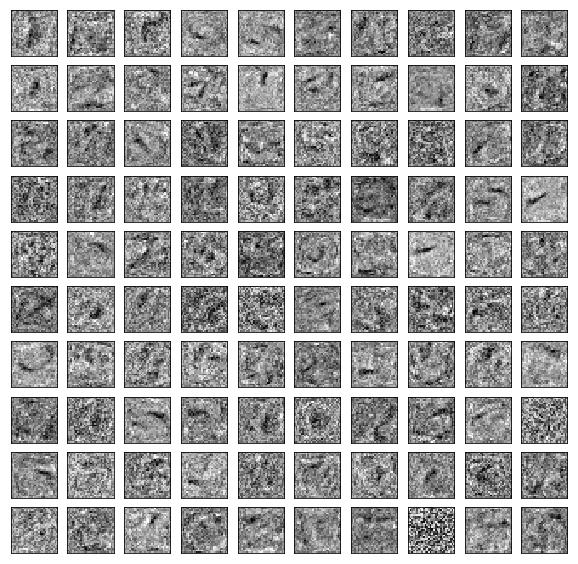

In [561]:
show_weights(list(model_mnist.parameters())[0].data.numpy().T, size=28)

### Подстановка весов из RBM

In [548]:
weights_rbm_mnist = torch.from_numpy(rbm_mnist.w[:-1, :-1].T / 20).type(torch.FloatTensor)
biases_rbm_mnist = torch.from_numpy(rbm_mnist.w[-1, :-1] / 20).type(torch.FloatTensor)

In [549]:
print(weights_rbm_mnist.max())
print(weights_rbm_mnist.min())
print(biases_rbm_mnist.max())
print(biases_rbm_mnist.min())

0.21109917759895325
-0.1587144136428833
0.2762775421142578
-0.23114265501499176


In [550]:
model_mnist_rbm = torch.nn.Sequential(
    torch.nn.Linear(D_in_mnist, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out_mnist),
    torch.nn.LogSoftmax(),
)

In [551]:
list(model_mnist_rbm[0].parameters())[0].data = weights_rbm_mnist
list(model_mnist_rbm[0].parameters())[1].data = biases_rbm_mnist

In [552]:
optimizer_mnist_rbm = torch.optim.Adam(model_mnist_rbm.parameters(), lr=learning_rate)

In [554]:
train_nn(model_mnist_rbm, optimizer_mnist_rbm, X_mnist_train_var_batches, y_mnist_train_var_batches, X_mnist_test_var, y_mnist_test)

Эпоха 0


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Точность на тестовой выборке 92.06%

Эпоха 1
Точность на тестовой выборке 93.89%

Эпоха 2
Точность на тестовой выборке 94.55%

Эпоха 3
Точность на тестовой выборке 95.66%

Эпоха 4
Точность на тестовой выборке 95.71%

Эпоха 5
Точность на тестовой выборке 93.80%

Эпоха 6
Точность на тестовой выборке 94.19%

Эпоха 7
Точность на тестовой выборке 94.75%

Эпоха 8
Точность на тестовой выборке 95.26%

Эпоха 9
Точность на тестовой выборке 95.69%

Эпоха 10
Точность на тестовой выборке 95.96%

Эпоха 11
Точность на тестовой выборке 95.68%

Эпоха 12
Точность на тестовой выборке 96.16%

Эпоха 13
Точность на тестовой выборке 96.23%

Эпоха 14
Точность на тестовой выборке 96.37%



Максимум: 0.16181905567646027, минимум: -0.2155534029006958


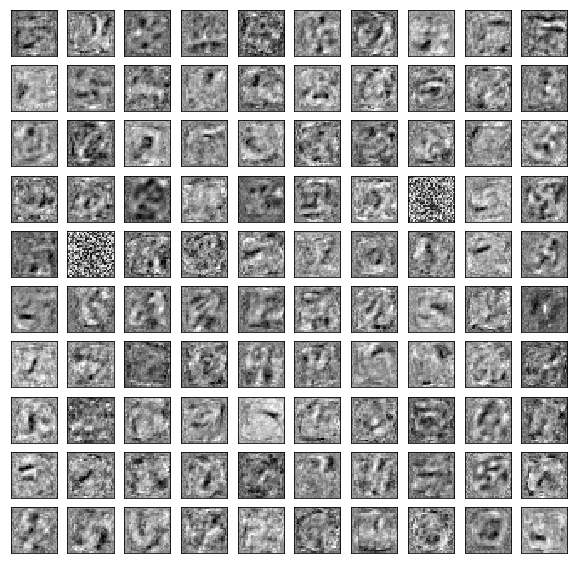

In [555]:
show_weights(list(model_mnist_rbm.parameters())[0].data.numpy().T, size=28)

## big alphabet

In [564]:
D_in_ba, D_out_ba = 841, 26

In [574]:
X_ba_train_var = torch.autograd.Variable(torch.from_numpy(X_ba_train.reshape((-1, 841))))
y_ba_train_var = torch.autograd.Variable(torch.from_numpy(y_ba_train).type(torch.LongTensor), requires_grad=False)

X_ba_train_var_batches = torch.autograd.Variable(torch.from_numpy(X_ba_train.reshape((16, 13, 841))))
y_ba_train_var_batches = torch.autograd.Variable(torch.from_numpy(y_ba_train.reshape((16, 13))).type(torch.LongTensor), requires_grad=False)

X_ba_test_var = torch.autograd.Variable(torch.from_numpy(X_ba_test.reshape((-1, 841))), requires_grad=False)

In [575]:
model_ba = torch.nn.Sequential(
    torch.nn.Linear(D_in_ba, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out_ba),
    torch.nn.LogSoftmax(),
)

In [576]:
optimizer_ba = torch.optim.Adam(model_ba.parameters(), lr=learning_rate)

In [586]:
train_nn(model_ba, optimizer_ba, X_ba_train_var_batches, y_ba_train_var_batches, X_ba_test_var, y_ba_test, epochs=50)

Эпоха 0
Точность на тестовой выборке 75.00%

Эпоха 1
Точность на тестовой выборке 75.00%

Эпоха 2
Точность на тестовой выборке 75.00%

Эпоха 3
Точность на тестовой выборке 75.00%

Эпоха 4
Точность на тестовой выборке 76.92%

Эпоха 5
Точность на тестовой выборке 76.92%

Эпоха 6


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Точность на тестовой выборке 76.92%

Эпоха 7
Точность на тестовой выборке 76.92%

Эпоха 8
Точность на тестовой выборке 76.92%

Эпоха 9
Точность на тестовой выборке 76.92%

Эпоха 10
Точность на тестовой выборке 76.92%

Эпоха 11
Точность на тестовой выборке 76.92%

Эпоха 12
Точность на тестовой выборке 76.92%

Эпоха 13
Точность на тестовой выборке 76.92%

Эпоха 14
Точность на тестовой выборке 76.92%

Эпоха 15
Точность на тестовой выборке 76.92%

Эпоха 16
Точность на тестовой выборке 76.92%

Эпоха 17
Точность на тестовой выборке 76.92%

Эпоха 18
Точность на тестовой выборке 76.92%

Эпоха 19
Точность на тестовой выборке 76.92%

Эпоха 20
Точность на тестовой выборке 78.85%

Эпоха 21
Точность на тестовой выборке 78.85%

Эпоха 22
Точность на тестовой выборке 78.85%

Эпоха 23
Точность на тестовой выборке 78.85%

Эпоха 24
Точность на тестовой выборке 78.85%

Эпоха 25
Точность на тестовой выборке 78.85%

Эпоха 26
Точность на тестовой выборке 78.85%

Эпоха 27
Точность на тестовой выборке 78.85%



Максимум: 0.04602263867855072, минимум: -0.048247624188661575


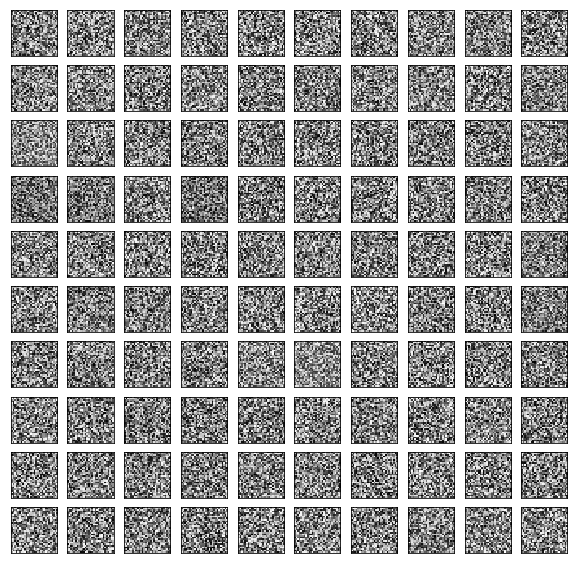

In [587]:
show_weights(list(model_ba.parameters())[0].data.numpy().T, size=29)

### Подстановка весов из RBM

In [579]:
weights_rbm_ba = torch.from_numpy(rbm_ba.w[:-1, :-1].T / 20).type(torch.FloatTensor)
biases_rbm_ba = torch.from_numpy(rbm_ba.w[-1, :-1] / 20).type(torch.FloatTensor)

In [580]:
print(weights_rbm_ba.max())
print(weights_rbm_ba.min())
print(biases_rbm_ba.max())
print(biases_rbm_ba.min())

0.07865745574235916
-0.07617828249931335
0.09175945073366165
-0.0312521792948246


In [588]:
model_ba_rbm = torch.nn.Sequential(
    torch.nn.Linear(D_in_ba, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out_ba),
    torch.nn.LogSoftmax(),
)

In [589]:
list(model_ba_rbm[0].parameters())[0].data = weights_rbm_ba
list(model_ba_rbm[0].parameters())[1].data = biases_rbm_ba

In [590]:
optimizer_ba_rbm = torch.optim.Adam(model_ba_rbm.parameters(), lr=learning_rate)

In [591]:
train_nn(model_ba_rbm, optimizer_ba_rbm, X_ba_train_var_batches, y_ba_train_var_batches, X_ba_test_var, y_ba_test, epochs=50)

Эпоха 0
Точность на тестовой выборке 13.46%

Эпоха 1
Точность на тестовой выборке 26.92%

Эпоха 2
Точность на тестовой выборке 36.54%

Эпоха 3
Точность на тестовой выборке 40.38%

Эпоха 4
Точность на тестовой выборке 50.00%

Эпоха 5
Точность на тестовой выборке 57.69%

Эпоха 6


/Users/oleg/anaconda3/envs/ve-pytorch/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Точность на тестовой выборке 67.31%

Эпоха 7
Точность на тестовой выборке 69.23%

Эпоха 8
Точность на тестовой выборке 76.92%

Эпоха 9
Точность на тестовой выборке 78.85%

Эпоха 10
Точность на тестовой выборке 82.69%

Эпоха 11
Точность на тестовой выборке 82.69%

Эпоха 12
Точность на тестовой выборке 82.69%

Эпоха 13
Точность на тестовой выборке 82.69%

Эпоха 14
Точность на тестовой выборке 82.69%

Эпоха 15
Точность на тестовой выборке 82.69%

Эпоха 16
Точность на тестовой выборке 82.69%

Эпоха 17
Точность на тестовой выборке 82.69%

Эпоха 18
Точность на тестовой выборке 82.69%

Эпоха 19
Точность на тестовой выборке 82.69%

Эпоха 20
Точность на тестовой выборке 82.69%

Эпоха 21
Точность на тестовой выборке 82.69%

Эпоха 22
Точность на тестовой выборке 82.69%

Эпоха 23
Точность на тестовой выборке 82.69%

Эпоха 24
Точность на тестовой выборке 82.69%

Эпоха 25
Точность на тестовой выборке 84.62%

Эпоха 26
Точность на тестовой выборке 84.62%

Эпоха 27
Точность на тестовой выборке 84.62%



Максимум: 0.07283317297697067, минимум: -0.07650334388017654


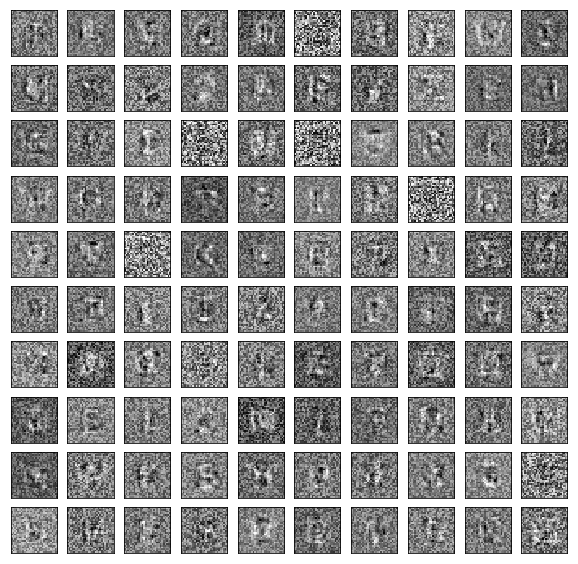

In [594]:
show_weights(list(model_ba_rbm.parameters())[0].data.numpy().T, size=29)

Простой вывод по результатам

Для маленьких датасетов предобучение с помощью ограниченной машины больцмана может улучшить качество классификатора. На больших датасетах (для однослойной сети) это эффект не заметен